In [61]:
import pandas as pd 
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

In [62]:
data = pd.read_csv('../data/gc_kronberg.csv', sep=';', decimal=',')

In [63]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36114 entries, 0 to 36113
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Wochentag        36114 non-null  object 
 1   Datum            36114 non-null  object 
 2   Startzeit        36114 non-null  object 
 3   Tage Saison      0 non-null      float64
 4   Max Kap          36114 non-null  int64  
 5   davon freie Kap  36114 non-null  int64  
 6   Auslastung %     36114 non-null  float64
 7   Gesamt           36114 non-null  int64  
 8   MGL Gesa.        36114 non-null  int64  
 9   Gäste            36114 non-null  int64  
 10  Jugend           36114 non-null  int64  
 11  MGL 18-40        36114 non-null  int64  
 12  MGL 40-50        36114 non-null  int64  
 13  MGL 50-65        36114 non-null  int64  
 14  MGL 65+          36114 non-null  int64  
 15  Sperrung.        36114 non-null  int64  
 16  Internet         36114 non-null  int64  
dtypes: float64(2

In [64]:
data['Datum'] = pd.to_datetime(data['Datum'], format='%d.%m.%y')
data["time"] = data["Startzeit"].apply(lambda x: x.split(" -")[0])

# add time to Datum column
data["Datum"] = data["Datum"].astype(str) + " " + data["time"]
data["Datum"] = pd.to_datetime(data["Datum"], format='%Y-%m-%d %H:%M:%S')

In [65]:
data

,Wochentag,Datum,Startzeit,Tage Saison,Max Kap,davon freie Kap,Auslastung %,Gesamt,MGL Gesa.,Gäste,Jugend,MGL 18-40,MGL 40-50,MGL 50-65,MGL 65+,Sperrung.,Internet,time
0,Do,2021-04-01 18:00:00,18:00 - 18:10,NaN,4,0,1.0,4,4,0,0,2,1,1,0,0,4,18:00
1,Fr,2021-04-02 08:50:00,08:50 - 09:00,NaN,4,0,1.0,4,4,0,1,1,0,2,0,0,3,08:50
2,Fr,2021-04-02 10:50:00,10:50 - 11:00,NaN,4,0,1.0,4,4,0,0,0,0,0,4,0,3,10:50
3,Fr,2021-04-02 11:30:00,11:30 - 11:40,NaN,4,0,1.0,4,4,0,0,0,0,2,2,0,4,11:30
4,Fr,2021-04-02 11:40:00,11:40 - 11:50,NaN,4,0,1.0,4,4,0,2,0,1,1,0,0,4,11:40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36109,Mo,2022-10-31 20:20:00,20:20 - 20:30,NaN,4,4,0.0,0,0,0,0,0,0,0,0,0,0,20:20
36110,Mo,2022-10-31 20:30:00,20:30 - 20:40,NaN,4,4,0.0,0,0,0,0,0,0,0,0,0,0,20:30
36111,Mo,2022-10-31 20:40:00,20:40 - 20:50,NaN,4,4,0.0,0,0,0,0,0,0,0,0,0,0,20:40
36112,Mo,2022-10-31 20:50:00,20:50 - 21:00,NaN,4,4,0.0,0,0,0,0,0,0,0,0,0,0,20:50


In [66]:
data["Auslastung Gesamt"] = data["Auslastung %"].replace(",", ".")
data["Auslastung Gäste"] = data["Gäste"]/4
data["Auslastung MGL Gesa."] = data["MGL Gesa."]/4
data["Auslastung MGL Jugend"] = data["Jugend"]/4
data["Auslastung MGL 18-40"] = data["MGL 18-40"]/4
data["Auslastung MGL 40-50"] = data["MGL 40-50"]/4
data["Auslastung MGL 50-65"] = data["MGL 50-65"]/4
data["Auslastung MGL 65+"] = data["MGL 65+"]/4

In [67]:
data.drop(columns=['Tage Saison'], inplace=True)

In [68]:
data.describe()

,Max Kap,davon freie Kap,Auslastung %,Gesamt,MGL Gesa.,Gäste,Jugend,MGL 18-40,MGL 40-50,MGL 50-65,...,Sperrung.,Internet,Auslastung Gesamt,Auslastung Gäste,Auslastung MGL Gesa.,Auslastung MGL Jugend,Auslastung MGL 18-40,Auslastung MGL 40-50,Auslastung MGL 50-65,Auslastung MGL 65+
count,36114.0,36114.000000,36114.000000,36114.000000,36114.000000,36114.000000,36114.000000,36114.000000,36114.000000,36114.000000,...,36114.000000,36114.000000,36114.000000,36114.000000,36114.000000,36114.000000,36114.000000,36114.000000,36114.000000,36114.000000
mean,4.0,3.387024,0.153244,0.612976,0.510024,0.102952,0.036053,0.035194,0.040760,0.153486,...,0.003157,0.447804,0.153244,0.025738,0.127506,0.009013,0.008799,0.010190,0.038372,0.061133
std,0.0,1.064210,0.266053,1.064210,0.957995,0.465437,0.235748,0.220904,0.234626,0.473839,...,0.056096,0.905438,0.266053,0.116359,0.239499,0.058937,0.055226,0.058657,0.118460,0.165715
min,4.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.0,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.0,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.0,4.000000,0.250000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.250000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000
max,4.0,4.000000,1.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,...,1.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [69]:
data['Jahr'] = data['Datum'].dt.year
data['Monat'] = data['Datum'].dt.month
data['Tag'] = data['Datum'].dt.day
data['Wochentag'] = data['Datum'].dt.dayofweek
data['Weekend'] = data['Wochentag'].apply(lambda x: 1 if x > 4 else 0)
data['Stunde'] = data['Datum'].dt.hour
data['Minute'] = data['Datum'].dt.minute
data.drop(columns=['Datum', 'Startzeit'], inplace=True)

In [70]:
wochentag = {0: 'Mo', 1: 'Di', 2: 'Mi', 3: 'Do', 4: 'Fr', 5: 'Sa', 6: 'So'}
data['Wochentag'] = data['Wochentag'].map(wochentag)

saison = {4: 'April - Mai', 5: 'April - Mai', 6: 'Juni - Juli', 7: 'Juni - Juli', 8: 'August - September', 9: 'August - September', 10: 'Oktober'}
data['Saison'] = data['Monat'].map(saison)

In [71]:
# show monat and saison
data[['Monat', 'Saison']].sort_values(by='Monat').drop_duplicates()

,Monat,Saison
0,4,April - Mai
12429,5,April - Mai
12835,6,Juni - Juli
28537,7,Juni - Juli
1413,8,August - September
33419,9,August - September
35384,10,Oktober


In [72]:
data = data.astype({
    'Auslastung %': 'float',
    'Jahr': 'int',
    'Monat': 'int',
    'Tag': 'int',
    'Weekend': 'bool'
})

In [73]:
data.sort_values(by="Monat")[['Monat', 'Auslastung %']]

,Monat,Auslastung %
0,4,1.0
22389,4,0.0
22390,4,0.0
22391,4,0.0
22392,4,0.0
...,...,...
19113,10,0.0
19114,10,0.0
19115,10,0.0
19106,10,0.0


In [74]:
import os
os.makedirs('../plots/gc_kronberg_barplots/', exist_ok=True)
os.makedirs('../plots/gc_kronberg_jahr_wochentag/', exist_ok=True)
os.makedirs('../plots/gc_kronberg_saison_wochentag/', exist_ok=True)
os.makedirs('../plots/gc_kronberg_jahr_startzeit/', exist_ok=True)
os.makedirs('../plots/gc_kronberg_saison_startzeit/', exist_ok=True)
os.makedirs('../plots/gc_kronberg_jahr_stunde/', exist_ok=True)
os.makedirs('../plots/gc_kronberg_saison_stunde/', exist_ok=True)
os.makedirs('../plots/gc_kronberg_jahr_monat/', exist_ok=True)

In [75]:
columns = ['davon freie Kap', 'Auslastung %', 'Internet', 'time', 'Auslastung Gesamt',
       'Auslastung Gäste', 'Auslastung MGL Gesa.', 'Auslastung MGL Jugend',
       'Auslastung MGL 18-40', 'Auslastung MGL 40-50', 'Auslastung MGL 50-65',
       'Auslastung MGL 65+', 'Jahr', 'Monat', 'Tag', 'Weekend', 'Saison',
       'Stunde', 'Minute']

monate = {
    1: "Jan",
    2: "Feb",
    3: "Mär",
    4: "Apr",
    5: "Mai",
    6: "Jun",
    7: "Jul",
    8: "Aug",
    9: "Sep",
    10: "Okt",
    11: "Nov",
    12: "Dez"
}

data["monat_text"] = data["Monat"].map(monate)

data[columns].describe()

,davon freie Kap,Auslastung %,Internet,Auslastung Gesamt,Auslastung Gäste,Auslastung MGL Gesa.,Auslastung MGL Jugend,Auslastung MGL 18-40,Auslastung MGL 40-50,Auslastung MGL 50-65,Auslastung MGL 65+,Jahr,Monat,Tag,Stunde,Minute
count,36114.000000,36114.000000,36114.000000,36114.000000,36114.000000,36114.000000,36114.000000,36114.000000,36114.000000,36114.000000,36114.000000,36114.000000,36114.000000,36114.000000,36114.000000,36114.000000
mean,3.387024,0.153244,0.447804,0.153244,0.025738,0.127506,0.009013,0.008799,0.010190,0.038372,0.061133,2021.540344,7.141801,15.793543,12.963200,24.533422
std,1.064210,0.266053,0.905438,0.266053,0.116359,0.239499,0.058937,0.055226,0.058657,0.118460,0.165715,0.498377,2.014312,8.868186,4.568945,17.271749
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2021.000000,4.000000,1.000000,0.000000,0.000000
25%,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2021.000000,5.000000,8.000000,9.000000,10.000000
50%,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2022.000000,7.000000,16.000000,13.000000,20.000000
75%,4.000000,0.250000,0.000000,0.250000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,2022.000000,9.000000,23.000000,17.000000,40.000000
max,4.000000,1.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2022.000000,10.000000,31.000000,21.000000,50.000000


In [76]:
data.to_csv('../data/gc_kronberg_cleaned.csv', index=False)
data.to_csv('../streamlit/gc_kronberg_cleaned.csv', index=False)

In [77]:
data

,Wochentag,Max Kap,davon freie Kap,Auslastung %,Gesamt,MGL Gesa.,Gäste,Jugend,MGL 18-40,MGL 40-50,...,Auslastung MGL 50-65,Auslastung MGL 65+,Jahr,Monat,Tag,Weekend,Stunde,Minute,Saison,monat_text
0,Do,4,0,1.0,4,4,0,0,2,1,...,0.25,0.0,2021,4,1,False,18,0,April - Mai,Apr
1,Fr,4,0,1.0,4,4,0,1,1,0,...,0.50,0.0,2021,4,2,False,8,50,April - Mai,Apr
2,Fr,4,0,1.0,4,4,0,0,0,0,...,0.00,1.0,2021,4,2,False,10,50,April - Mai,Apr
3,Fr,4,0,1.0,4,4,0,0,0,0,...,0.50,0.5,2021,4,2,False,11,30,April - Mai,Apr
4,Fr,4,0,1.0,4,4,0,2,0,1,...,0.25,0.0,2021,4,2,False,11,40,April - Mai,Apr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36109,Mo,4,4,0.0,0,0,0,0,0,0,...,0.00,0.0,2022,10,31,False,20,20,Oktober,Okt
36110,Mo,4,4,0.0,0,0,0,0,0,0,...,0.00,0.0,2022,10,31,False,20,30,Oktober,Okt
36111,Mo,4,4,0.0,0,0,0,0,0,0,...,0.00,0.0,2022,10,31,False,20,40,Oktober,Okt
36112,Mo,4,4,0.0,0,0,0,0,0,0,...,0.00,0.0,2022,10,31,False,20,50,Oktober,Okt


In [78]:
data.groupby(["Jahr", "Monat", "Stunde"])["Auslastung Gesamt"].describe().sort_values(by="mean", ascending=True).head(20)

count  mean  std  min  25%  50%  75%  max
Jahr Monat Stunde                                           
2021 10    21       31.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
     6     21       19.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
     7     0        31.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
           21       30.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
     8     21       31.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
     9     20      180.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
           21       30.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
     10    0        30.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
           19      186.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
           20      186.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
2022 10    20      186.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
     4     0        30.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
           21       30.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
     5     21       31.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
     6     20      180.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
           21       30.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
     7     21       31.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
     8     0        30.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
           20      186.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
           21       31.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0

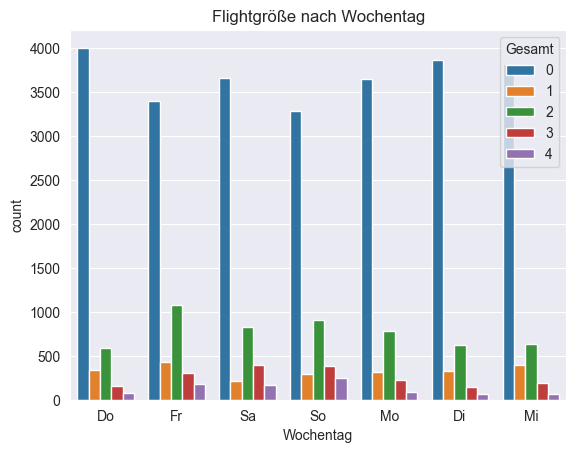

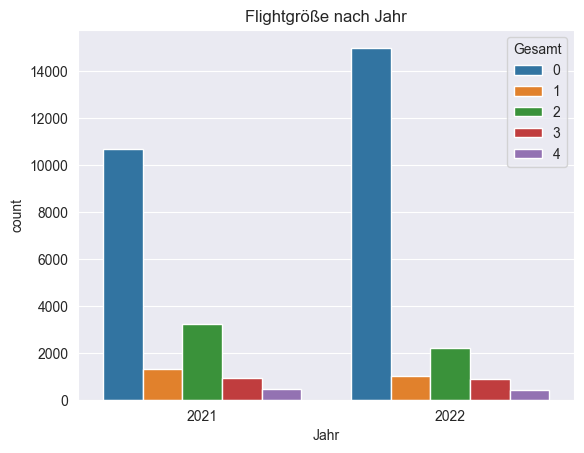

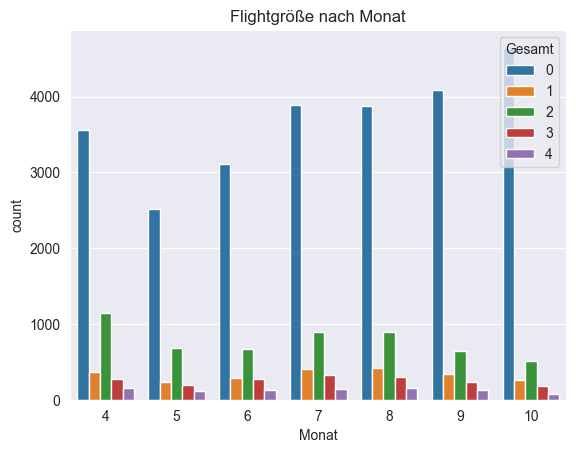

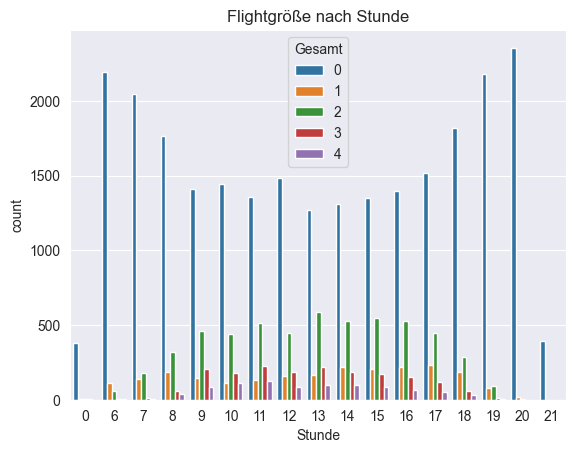

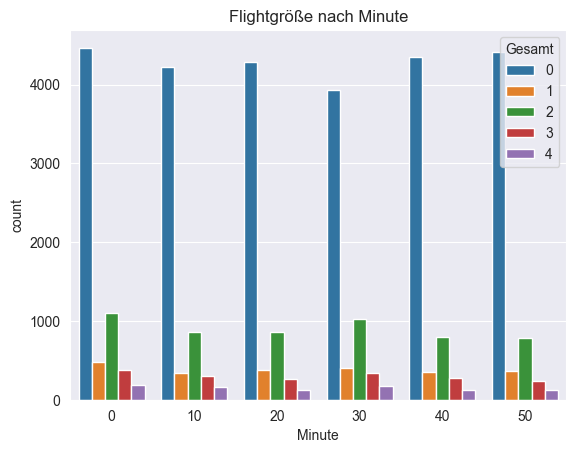

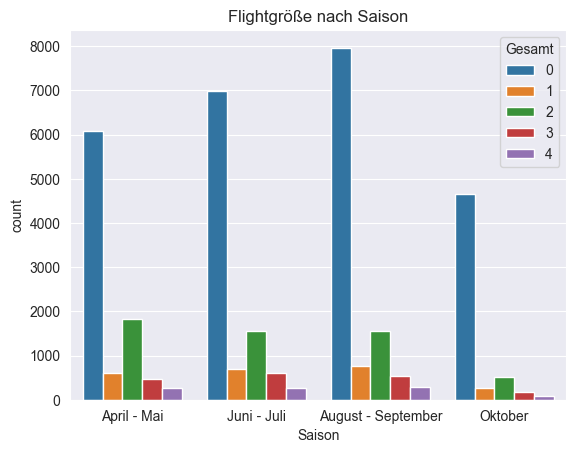

In [79]:
for col in data.columns:
        if col in ['Jahr', 'Monat', 'Wochentag', 'Saison', 'Stunde', 'Minute']:
            sns.countplot(x=col, data=data, hue="Gesamt")
            plt.title(f'Flightgröße nach {col}')
            plt.savefig(f'../plots/gc_kronberg_barplots/{col}.png')
            plt.show()

In [80]:
for col in data.columns:
    if col not in ["Auslastung %", "Gesamt", 'Jahr', 'Monat', 'Tag', 'Wochentag', 'Saison', 'Max Kap', 'Sperrung.', 'Internet', 'Weekend', 'Stunde', 'Minute', 'time', "davon freie Kap", "Gäste", "MGL Gesa.", "Jugend", "MGL 18-40", "MGL 40-50", "MGL 50-65", "MGL 65+"]:
        data2 = data.groupby(['Jahr', "Monat"])[col].mean()
        data2 = data2.reset_index()
        fig = px.line(data2, x='Monat', y=col, color='Jahr', title=f'Auslastung GC Kronberg {col} in % pro Monat und Jahr 2021 - 2022', labels={'Monat': 'Monat', 'Jahr': 'Jahr', col: 'Auslastung in %'})
        
        #plot data in the same graph
        data3 = data.groupby(["Monat"])[col].mean()
        data3 = data3.reset_index()
       # fig.add_trace(go.Scatter(x=data3["Wochentag"], y=data3[col], mode="lines", name="Durchschnitt", marker=dict(color="Black", size=10)))
        fig.layout.yaxis.tickformat = ',.0%'
        
        fig.update_xaxes(tickvals=[1,2,3,4,5,6,7,8,9,10,11,12], ticktext=['Januar', 'Februar', 'März', 'April', 'Mai', 'Juni', 'Juli', 'August', 'September', 'Oktober', 'November', 'Dezember'])
        
        fig.update_layout(width=1600)
        
        data2_2021 = data2[data2["Jahr"] == 2021]
        data2_2022 = data2[data2["Jahr"] == 2022]
        
        # markiere max und min für jedes Jahr
        fig.add_trace(go.Scatter(x=[data2_2021[data2_2021[col] == data2_2021[col].max()]["Monat"].values[0]], y=[data2_2021[col].max()], mode="markers", name="Höchste Auslastung 2021", marker=dict(color="Green", size=10)))
        fig.add_trace(go.Scatter(x=[data2_2021[data2_2021[col] == data2_2021[col].min()]["Monat"].values[0]], y=[data2_2021[col].min()], mode="markers", name="Geringste Auslastung 2021", marker=dict(color="Orange", size=10)))
        fig.add_trace(go.Scatter(x=[data2_2022[data2_2022[col] == data2_2022[col].max()]["Monat"].values[0]], y=[data2_2022[col].max()], mode="markers", name="Höchste Auslastung 2022", marker=dict(color="Red", size=10)))
        fig.add_trace(go.Scatter(x=[data2_2022[data2_2022[col] == data2_2022[col].min()]["Monat"].values[0]], y=[data2_2022[col].min()], mode="markers", name="Geringste Auslastung 2022", marker=dict(color="Purple", size=10)))
           
        fig.write_image(f"../plots/gc_kronberg_jahr_monat/{col}.png")
        fig.show()


TypeError: Could not convert AprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprAprApr to numeric

In [ ]:
for col in data.columns:
    if col not in ["Auslastung %", "Gesamt", 'Jahr', 'Monat', 'Tag', 'Wochentag', 'Saison', 'Max Kap', 'Sperrung.', 'Internet', 'Weekend', 'Stunde', 'Minute', 'time', "davon freie Kap", "Gäste", "MGL Gesa.", "Jugend", "MGL 18-40", "MGL 40-50", "MGL 50-65", "MGL 65+"]:
        data2 = data.groupby(['Jahr', "Wochentag"])[col].mean()
        data2 = data2.reset_index()
        weekday_order = ["Mo", "Di", "Mi", "Do", "Fr", "Sa", "So"]
        data2["Wochentag"] = pd.Categorical(data2["Wochentag"], categories=weekday_order, ordered=True)
        data2 = data2.sort_values(by=["Wochentag"])
        fig = px.line(data2, x='Wochentag', y=col, color='Jahr', title=f'Auslastung GC Kronberg {col} in % pro Wochentag für 2021 und 2022', labels={'Wochentag': 'Wochentag', 'value': 'Auslastung in %', 'Jahr': 'Jahr'})
        
        #plot data in the same graph
        data3 = data.groupby(["Wochentag"])[col].mean()
        data3 = data3.reset_index()
       # fig.add_trace(go.Scatter(x=data3["Wochentag"], y=data3[col], mode="lines", name="Durchschnitt", marker=dict(color="Black", size=10)))
        fig.layout.yaxis.tickformat = ',.0%'
        
        fig.update_layout(width=1600)
        
        data2_2021 = data2[data2["Jahr"] == 2021]
        data2_2022 = data2[data2["Jahr"] == 2022]
        
        # markiere max und min für jedes Jahr
        fig.add_trace(go.Scatter(x=[data2_2021[data2_2021[col] == data2_2021[col].max()]["Wochentag"].values[0]], y=[data2_2021[col].max()], mode="markers", name="Höchste Auslastung 2021", marker=dict(color="Green", size=10)))
        fig.add_trace(go.Scatter(x=[data2_2021[data2_2021[col] == data2_2021[col].min()]["Wochentag"].values[0]], y=[data2_2021[col].min()], mode="markers", name="Geringste Auslastung 2021", marker=dict(color="Orange", size=10)))
        fig.add_trace(go.Scatter(x=[data2_2022[data2_2022[col] == data2_2022[col].max()]["Wochentag"].values[0]], y=[data2_2022[col].max()], mode="markers", name="Höchste Auslastung 2022", marker=dict(color="Red", size=10)))
        fig.add_trace(go.Scatter(x=[data2_2022[data2_2022[col] == data2_2022[col].min()]["Wochentag"].values[0]], y=[data2_2022[col].min()], mode="markers", name="Geringste Auslastung 2022", marker=dict(color="Purple", size=10)))
           
       # fig.add_trace(go.Scatter(x=[data3[data3[col] == data3[col].max()]["Wochentag"].values[0]], y=[data3[col].max()], mode="markers", name="Höchste Auslastung 21/22", marker=dict(color="Black", size=10)))
       # fig.add_trace(go.Scatter(x=[data3[data3[col] == data3[col].min()]["Wochentag"].values[0]], y=[data3[col].min()], mode="markers", name="Geringste Auslastung 21/22", marker=dict(color="Yellow", size=10)))
     
        fig.write_image(f"../plots/gc_kronberg_jahr_wochentag/{col}.png")
        fig.show()
        fig.add_shape(type="line", x0=0, y0=1, x1=max(data2["Wochentag"]), y1=1, line=dict(color="Red", width=2))
        fig.write_image(f"../plots/gc_kronberg_jahr_wochentag/{col}_with_max.png")
       # fig.show()

In [ ]:
for col in data.columns:
    if col not in ["Auslastung %", "Gesamt", 'Jahr', 'Monat', 'Tag', 'Wochentag', 'Saison', 'Max Kap', 'Sperrung.', 'Internet', 'Weekend', 'Stunde', 'Minute', 'time', "davon freie Kap", "Gäste", "MGL Gesa.", "Jugend", "MGL 18-40", "MGL 40-50", "MGL 50-65", "MGL 65+"]:
        data2 = data.groupby(['Saison', "Wochentag"])[col].mean()
        data2 = data2.reset_index()
        weekday_order = ["Mo", "Di", "Mi", "Do", "Fr", "Sa", "So"]
        data2["Wochentag"] = pd.Categorical(data2["Wochentag"], categories=weekday_order, ordered=True)
        saison_order = ["April - Mai", "Juni - Juli", "August - September", "Oktober"]
        data2["Saison"] = pd.Categorical(data2["Saison"], categories=saison_order, ordered=True)
        data2 = data2.sort_values(by=["Saison", "Wochentag"])
        fig = px.line(data2, x='Wochentag', y=col, color='Saison', title=f'Auslastung GC Kronberg {col} in % pro Wochentag für Jahreszeiten in 2021 und 2022', labels={'Wochentag': 'Wochentag', col: 'Auslastung in %', 'Saison': 'Saison'})
        
        #plot data in the same graph
        data3 = data.groupby(["Wochentag"])[col].mean()
        data3 = data3.reset_index()
        
        # fig.add_trace(go.Scatter(x=data3["Wochentag"], y=data3[col], mode="lines", name="Durchschnitt", marker=dict(color="Black", size=10)))
        fig.layout.yaxis.tickformat = ',.0%'
        
        fig.update_layout(width=1600)
        
        data2_apr_mai = data2[data2["Saison"] == "April - Mai"]
        data2_juni_juli = data2[data2["Saison"] == "Juni - Juli"]
        data2_aug_sept = data2[data2["Saison"] == "August - September"]
        data2_okt = data2[data2["Saison"] == "Oktober"]
        
        # markiere max und min für jedes Jahr
        fig.add_trace(go.Scatter(x=[data2_apr_mai[data2_apr_mai[col] == data2_apr_mai[col].max()]["Wochentag"].values[0]], y=[data2_apr_mai[col].max()], mode="markers", name="Höchste Auslastung April - Mai", marker=dict(color="Green", size=10)))
        fig.add_trace(go.Scatter(x=[data2_apr_mai[data2_apr_mai[col] == data2_apr_mai[col].min()]["Wochentag"].values[0]], y=[data2_apr_mai[col].min()], mode="markers", name="Geringste Auslastung April - Mai", marker=dict(color="Orange", size=10)))
        fig.add_trace(go.Scatter(x=[data2_juni_juli[data2_juni_juli[col] == data2_juni_juli[col].max()]["Wochentag"].values[0]], y=[data2_juni_juli[col].max()], mode="markers", name="Höchste Auslastung Juni - Juli", marker=dict(color="Red", size=10)))
        fig.add_trace(go.Scatter(x=[data2_juni_juli[data2_juni_juli[col] == data2_juni_juli[col].min()]["Wochentag"].values[0]], y=[data2_juni_juli[col].min()], mode="markers", name="Geringste Auslastung Juni - Juli", marker=dict(color="Purple", size=10)))
        fig.add_trace(go.Scatter(x=[data2_aug_sept[data2_aug_sept[col] == data2_aug_sept[col].max()]["Wochentag"].values[0]], y=[data2_aug_sept[col].max()], mode="markers", name="Höchste Auslastung August - September", marker=dict(color="Blue", size=10))) 
        fig.add_trace(go.Scatter(x=[data2_aug_sept[data2_aug_sept[col] == data2_aug_sept[col].min()]["Wochentag"].values[0]], y=[data2_aug_sept[col].min()], mode="markers", name="Geringste Auslastung August - September", marker=dict(color="Pink", size=10)))
        fig.add_trace(go.Scatter(x=[data2_okt[data2_okt[col] == data2_okt[col].max()]["Wochentag"].values[0]], y=[data2_okt[col].max()], mode="markers", name="Höchste Auslastung Oktober", marker=dict(color="Brown", size=10)))
        fig.add_trace(go.Scatter(x=[data2_okt[data2_okt[col] == data2_okt[col].min()]["Wochentag"].values[0]], y=[data2_okt[col].min()], mode="markers", name="Geringste Auslastung Oktober", marker=dict(color="Grey", size=10)))
         
        #fig.add_trace(go.Scatter(x=[data3[data3[col] == data3[col].max()]["Wochentag"].values[0]], y=[data3[col].max()], mode="markers", name="Höchste Auslastung 21/22", marker=dict(color="Black", size=10)))
        #fig.add_trace(go.Scatter(x=[data3[data3[col] == data3[col].min()]["Wochentag"].values[0]], y=[data3[col].min()], mode="markers", name="Geringste Auslastung 21/22", marker=dict(color="Yellow", size=10)))
     
        fig.write_image(f"../plots/gc_kronberg_saison_wochentag/{col}.png")
        fig.show()
        fig.add_shape(type="line", x0=0, y0=1, x1=max(data2["Wochentag"]), y1=1, line=dict(color="Red", width=2))
        fig.write_image(f"../plots/gc_kronberg_saison_wochentag/{col}_with_max.png")
       # fig.show()

In [ ]:
for col in data.columns:
    if col not in ["Auslastung %", "Gesamt", 'Jahr', 'Monat', 'Tag', 'Wochentag', 'Saison', 'Max Kap', 'Sperrung.', 'Internet', 'Weekend', 'Stunde', 'Minute', 'time', "davon freie Kap", "Gäste", "MGL Gesa.", "Jugend", "MGL 18-40", "MGL 40-50", "MGL 50-65", "MGL 65+"]:
        data2 = data.groupby(['Jahr', "time"])[col].mean()
        data2 = data2.reset_index()
        fig = px.line(data2, x='time', y=col, color='Jahr', title=f'Auslastung GC Kronberg {col} in % pro Startzeit für 2021 und 2022', labels={'time': 'Startzeit', col: 'Auslastung in %'})
        
        #plot data in the same graph
        data3 = data.groupby(["time"])[col].mean()
        data3 = data3.reset_index()
       # fig.add_trace(go.Scatter(x=data3["time"], y=data3[col], mode="lines", name="Durchschnitt", marker=dict(color="Black", size=10)))
        fig.layout.yaxis.tickformat = ',.0%'
        
        fig.update_layout(width=1600)
            
        data2_2021 = data2[data2["Jahr"] == 2021]
        data2_2022 = data2[data2["Jahr"] == 2022]
        
        # markiere max und min für jedes Jahr
        fig.add_trace(go.Scatter(x=[data2_2021[data2_2021[col] == data2_2021[col].max()]["time"].values[0]], y=[data2_2021[col].max()], mode="markers", name="Höchste Auslastung 2021", marker=dict(color="Green", size=10)))
        fig.add_trace(go.Scatter(x=[data2_2021[data2_2021[col] == data2_2021[col].min()]["time"].values[0]], y=[data2_2021[col].min()], mode="markers", name="Geringste Auslastung 2021", marker=dict(color="Orange", size=10)))
        fig.add_trace(go.Scatter(x=[data2_2022[data2_2022[col] == data2_2022[col].max()]["time"].values[0]], y=[data2_2022[col].max()], mode="markers", name="Höchste Auslastung 2022", marker=dict(color="Red", size=10)))
        fig.add_trace(go.Scatter(x=[data2_2022[data2_2022[col] == data2_2022[col].min()]["time"].values[0]], y=[data2_2022[col].min()], mode="markers", name="Geringste Auslastung 2022", marker=dict(color="Purple", size=10)))
           
        #fig.add_trace(go.Scatter(x=[data3[data3[col] == data3[col].max()]["time"].values[0]], y=[data3[col].max()], mode="markers", name="Höchste Auslastung 21/22", marker=dict(color="Black", size=10)))
       # fig.add_trace(go.Scatter(x=[data3[data3[col] == data3[col].min()]["time"].values[0]], y=[data3[col].min()], mode="markers", name="Geringste Auslastung 21/22", marker=dict(color="Yellow", size=10)))
     
        fig.write_image(f"../plots/gc_kronberg_jahr_startzeit/{col}.png")
        fig.show()
        fig.add_shape(type="line", x0=0, y0=1, x1=max(data2["time"]), y1=1, line=dict(color="Red", width=2))
        fig.write_image(f"../plots/gc_kronberg_jahr_startzeit/{col}_with_max.png")
       # fig.show()

In [ ]:
for col in data.columns:
    if col not in ["Auslastung %", "Gesamt", 'Jahr', 'Monat', 'Tag', 'Wochentag', 'Saison', 'Max Kap', 'Sperrung.', 'Internet', 'Weekend', 'Stunde', 'Minute', 'time', "davon freie Kap", "Gäste", "MGL Gesa.", "Jugend", "MGL 18-40", "MGL 40-50", "MGL 50-65", "MGL 65+"]:
        data2 = data.groupby(['Saison', "time"])[col].mean()
        data2 = data2.reset_index()
        fig = px.line(data2, x='time', y=col, color='Saison', title=f'Auslastung GC Kronberg {col} in % pro Startzeit für Saison in 2021 und 2022', labels={'time': 'Startzeit', col: 'Auslastung in %'})
        
        #plot data in the same graph
        data3 = data.groupby(["time"])[col].mean()
        data3 = data3.reset_index()
       # fig.add_trace(go.Scatter(x=data3["Wochentag"], y=data3[col], mode="lines", name="Durchschnitt", marker=dict(color="Black", size=10)))
        fig.layout.yaxis.tickformat = ',.0%'
        
        fig.update_layout(width=2000)

        
        data2_apr_mai = data2[data2["Saison"] == "April - Mai"]
        data2_juni_juli = data2[data2["Saison"] == "Juni - Juli"]
        data2_aug_sept = data2[data2["Saison"] == "August - September"]
        data2_okt = data2[data2["Saison"] == "Oktober"]
        
        # markiere max und min für jedes Jahr
        fig.add_trace(go.Scatter(x=[data2_apr_mai[data2_apr_mai[col] == data2_apr_mai[col].max()]["time"].values[0]], y=[data2_apr_mai[col].max()], mode="markers", name="Höchste Auslastung April - Mai", marker=dict(color="Green", size=10)))
        fig.add_trace(go.Scatter(x=[data2_apr_mai[data2_apr_mai[col] == data2_apr_mai[col].min()]["time"].values[0]], y=[data2_apr_mai[col].min()], mode="markers", name="Geringste Auslastung April - Mai", marker=dict(color="Orange", size=10)))
        fig.add_trace(go.Scatter(x=[data2_juni_juli[data2_juni_juli[col] == data2_juni_juli[col].max()]["time"].values[0]], y=[data2_juni_juli[col].max()], mode="markers", name="Höchste Auslastung Juni - Juli", marker=dict(color="Red", size=10)))
        fig.add_trace(go.Scatter(x=[data2_juni_juli[data2_juni_juli[col] == data2_juni_juli[col].min()]["time"].values[0]], y=[data2_juni_juli[col].min()], mode="markers", name="Geringste Auslastung Juni - Juli", marker=dict(color="Purple", size=10)))
        fig.add_trace(go.Scatter(x=[data2_aug_sept[data2_aug_sept[col] == data2_aug_sept[col].max()]["time"].values[0]], y=[data2_aug_sept[col].max()], mode="markers", name="Höchste Auslastung August - September", marker=dict(color="Blue", size=10))) 
        fig.add_trace(go.Scatter(x=[data2_aug_sept[data2_aug_sept[col] == data2_aug_sept[col].min()]["time"].values[0]], y=[data2_aug_sept[col].min()], mode="markers", name="Geringste Auslastung August - September", marker=dict(color="Pink", size=10)))
        fig.add_trace(go.Scatter(x=[data2_okt[data2_okt[col] == data2_okt[col].max()]["time"].values[0]], y=[data2_okt[col].max()], mode="markers", name="Höchste Auslastung Oktober", marker=dict(color="Brown", size=10)))
        fig.add_trace(go.Scatter(x=[data2_okt[data2_okt[col] == data2_okt[col].min()]["time"].values[0]], y=[data2_okt[col].min()], mode="markers", name="Geringste Auslastung Oktober", marker=dict(color="Grey", size=10)))
     
          
        #fig.add_trace(go.Scatter(x=[data3[data3[col] == data3[col].max()]["Wochentag"].values[0]], y=[data3[col].max()], mode="markers", name="Höchste Auslastung 21/22", marker=dict(color="Black", size=10)))
        #fig.add_trace(go.Scatter(x=[data3[data3[col] == data3[col].min()]["Wochentag"].values[0]], y=[data3[col].min()], mode="markers", name="Geringste Auslastung 21/22", marker=dict(color="Yellow", size=10)))
     
        fig.write_image(f"../plots/gc_kronberg_saison_startzeit/{col}.png")
        fig.show()
        fig.add_shape(type="line", x0=0, y0=1, x1=max(data2["time"]), y1=1, line=dict(color="Red", width=2))
        fig.write_image(f"../plots/gc_kronberg_saison_startzeit/{col}_with_max.png")
       # fig.show()

In [ ]:
for col in data.columns:
    if col not in ["Auslastung %", "Gesamt", 'Jahr', 'Monat', 'Tag', 'Wochentag', 'Saison', 'Max Kap', 'Sperrung.', 'Internet', 'Weekend', 'Stunde', 'Minute', 'time', "davon freie Kap", "Gäste", "MGL Gesa.", "Jugend", "MGL 18-40", "MGL 40-50", "MGL 50-65", "MGL 65+"]:
        data2 = data[data["Stunde"].isin([6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22])]
        data2 = data2.groupby(['Jahr', "Stunde"])[col].mean()
        data2 = data2.reset_index()
        fig = px.line(data2, x='Stunde', y=col, color='Jahr', title=f'Auslastung GC Kronberg {col} in % pro Stunde für 2021 und 2022', labels={'Stunde': 'Stunde', col: 'Auslastung in %'})
        
        #plot data in the same graph
        data3 = data.groupby(["Stunde"])[col].mean()
        data3 = data3.reset_index()
       # fig.add_trace(go.Scatter(x=data3["Stunde"], y=data3[col], mode="lines", name="Durchschnitt", marker=dict(color="Black", size=10)))
        
        fig.layout.yaxis.tickformat = ',.0%'
        fig.update_xaxes(tickvals=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23])
        
        fig.update_layout(width=1600)
            
        data2_2021 = data2[data2["Jahr"] == 2021]
        data2_2022 = data2[data2["Jahr"] == 2022]
        
        # markiere max und min für jedes Jahr
        fig.add_trace(go.Scatter(x=[data2_2021[data2_2021[col] == data2_2021[col].max()]["Stunde"].values[0]], y=[data2_2021[col].max()], mode="markers", name="Höchste Auslastung 2021", marker=dict(color="Green", size=10)))
        fig.add_trace(go.Scatter(x=[data2_2021[data2_2021[col] == data2_2021[col].min()]["Stunde"].values[0]], y=[data2_2021[col].min()], mode="markers", name="Geringste Auslastung 2021", marker=dict(color="Orange", size=10)))
        fig.add_trace(go.Scatter(x=[data2_2022[data2_2022[col] == data2_2022[col].max()]["Stunde"].values[0]], y=[data2_2022[col].max()], mode="markers", name="Höchste Auslastung 2022", marker=dict(color="Red", size=10)))
        fig.add_trace(go.Scatter(x=[data2_2022[data2_2022[col] == data2_2022[col].min()]["Stunde"].values[0]], y=[data2_2022[col].min()], mode="markers", name="Geringste Auslastung 2022", marker=dict(color="Purple", size=10)))
           
     #   fig.add_trace(go.Scatter(x=[data3[data3[col] == data3[col].max()]["Stunde"].values[0]], y=[data3[col].max()], mode="markers", name="Höchste Auslastung 21/22", marker=dict(color="Black", size=10)))
      #  fig.add_trace(go.Scatter(x=[data3[data3[col] == data3[col].min()]["Stunde"].values[0]], y=[data3[col].min()], mode="markers", name="Geringste Auslastung 21/22", marker=dict(color="Yellow", size=10)))
     
        fig.write_image(f"../plots/gc_kronberg_jahr_stunde/{col}.png")
        fig.show()
        fig.add_shape(type="line", x0=0, y0=1, x1=max(data2["Stunde"]), y1=1, line=dict(color="Red", width=2))
        fig.write_image(f"../plots/gc_kronberg_jahr_stunde/{col}_with_max.png")
       # fig.show()

In [ ]:
for col in data.columns:
    if col not in ["Auslastung %", "Gesamt", 'Jahr', 'Monat', 'Tag', 'Wochentag', 'Saison', 'Max Kap', 'Sperrung.', 'Internet', 'Weekend', 'Stunde', 'Minute', 'time', "davon freie Kap", "Gäste", "MGL Gesa.", "Jugend", "MGL 18-40", "MGL 40-50", "MGL 50-65", "MGL 65+"]:
        data2 = data[data["Stunde"].isin([6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22])]
        data2 = data2.groupby(['Saison', "Stunde"])[col].mean()
        data2 = data2.reset_index()
        fig = px.line(data2, x='Stunde', y=col, color='Saison', title=f'Auslastung GC Kronberg {col} in % pro Stunde für Saison in 2021 und 2022', labels={'Stunde': 'Stunde', col: 'Auslastung in %'})
        
        #plot data in the same graph
        data3 = data.groupby(["Stunde"])[col].mean()
        data3 = data3.reset_index()
       # fig.add_trace(go.Scatter(x=data3["Wochentag"], y=data3[col], mode="lines", name="Durchschnitt", marker=dict(color="Black", size=10)))
        
        fig.layout.yaxis.tickformat = ',.0%'
        
        fig.update_xaxes(tickvals=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23])
        
        fig.update_layout(width=1600)

        data2_apr_mai = data2[data2["Saison"] == "April - Mai"]
        data2_juni_juli = data2[data2["Saison"] == "Juni - Juli"]
        data2_aug_sept = data2[data2["Saison"] == "August - September"]
        data2_okt = data2[data2["Saison"] == "Oktober"]
        
        # markiere max und min für jedes Jahr
        fig.add_trace(go.Scatter(x=[data2_apr_mai[data2_apr_mai[col] == data2_apr_mai[col].max()]["Stunde"].values[0]], y=[data2_apr_mai[col].max()], mode="markers", name="Höchste Auslastung April - Mai", marker=dict(color="Green", size=10)))
        fig.add_trace(go.Scatter(x=[data2_apr_mai[data2_apr_mai[col] == data2_apr_mai[col].min()]["Stunde"].values[0]], y=[data2_apr_mai[col].min()], mode="markers", name="Geringste Auslastung April - Mai", marker=dict(color="Orange", size=10)))
        fig.add_trace(go.Scatter(x=[data2_juni_juli[data2_juni_juli[col] == data2_juni_juli[col].max()]["Stunde"].values[0]], y=[data2_juni_juli[col].max()], mode="markers", name="Höchste Auslastung Juni - Juli", marker=dict(color="Red", size=10)))
        fig.add_trace(go.Scatter(x=[data2_juni_juli[data2_juni_juli[col] == data2_juni_juli[col].min()]["Stunde"].values[0]], y=[data2_juni_juli[col].min()], mode="markers", name="Geringste Auslastung Juni - Juli", marker=dict(color="Purple", size=10)))
        fig.add_trace(go.Scatter(x=[data2_aug_sept[data2_aug_sept[col] == data2_aug_sept[col].max()]["Stunde"].values[0]], y=[data2_aug_sept[col].max()], mode="markers", name="Höchste Auslastung August - September", marker=dict(color="Blue", size=10))) 
        fig.add_trace(go.Scatter(x=[data2_aug_sept[data2_aug_sept[col] == data2_aug_sept[col].min()]["Stunde"].values[0]], y=[data2_aug_sept[col].min()], mode="markers", name="Geringste Auslastung August - September", marker=dict(color="Pink", size=10)))
        fig.add_trace(go.Scatter(x=[data2_okt[data2_okt[col] == data2_okt[col].max()]["Stunde"].values[0]], y=[data2_okt[col].max()], mode="markers", name="Höchste Auslastung Oktober", marker=dict(color="Brown", size=10)))
        fig.add_trace(go.Scatter(x=[data2_okt[data2_okt[col] == data2_okt[col].min()]["Stunde"].values[0]], y=[data2_okt[col].min()], mode="markers", name="Geringste Auslastung Oktober", marker=dict(color="Grey", size=10)))
          
        #fig.add_trace(go.Scatter(x=[data3[data3[col] == data3[col].max()]["Wochentag"].values[0]], y=[data3[col].max()], mode="markers", name="Höchste Auslastung 21/22", marker=dict(color="Black", size=10)))
        #fig.add_trace(go.Scatter(x=[data3[data3[col] == data3[col].min()]["Wochentag"].values[0]], y=[data3[col].min()], mode="markers", name="Geringste Auslastung 21/22", marker=dict(color="Yellow", size=10)))
     
        fig.write_image(f"../plots/gc_kronberg_saison_stunde/{col}.png")
        fig.show()
        fig.add_shape(type="line", x0=0, y0=1, x1=max(data2["Stunde"]), y1=1, line=dict(color="Red", width=2))
        fig.write_image(f"../plots/gc_kronberg_saison_stunde/{col}_with_max.png")
       # fig.show()

In [ ]:
data_2021 = data[data["Jahr"] == 2021]
data_2022 = data[data["Jahr"] == 2022]

plot_data_2021 = data_2021.groupby(["Wochentag", "time"])["Auslastung %"].mean().reset_index()
plot_data_2022 = data_2022.groupby(["Wochentag", "time"])["Auslastung %"].mean().reset_index()
plot_data_both = data.groupby(["Wochentag", "time"])["Auslastung %"].mean().reset_index()

day_dict = {"Mo": "Montag", "Di": "Dienstag", "Mi": "Mittwoch", "Do": "Donnerstag", "Fr": "Freitag", "Sa": "Samstag", "So": "Sonntag"}

os.makedirs("../plots/gc_kronberg_tag_startzeit", exist_ok=True)

for day in data_2021["Wochentag"].unique():
    data2 = plot_data_2021[plot_data_2021["Wochentag"] == day]
    data3 = plot_data_2022[plot_data_2022["Wochentag"] == day]
    fig = px.line(data2, x='time', y="Auslastung %", title=f'Auslastung der Startzeiten in % für {day_dict[day]}e in 2021', labels={'time': 'Startzeit', 'Auslastung %': 'Auslastung in %'})
    fig.update_layout(width=1600)
    fig.update_yaxes(tickformat = ',.0%')
    fig.show()
    
    fig2 = px.line(data3, x='time', y="Auslastung %", title=f'Auslastung der Startzeiten in % für {day_dict[day]}e in 2022', labels={'time': 'Startzeit', 'Auslastung %': 'Auslastung in %'})
    fig2.update_layout(width=1600)
    fig2.update_yaxes(tickformat = ',.0%')
    fig2.show()
    
    fig3 = px.line(plot_data_both[plot_data_both["Wochentag"] == day], x='time', y="Auslastung %", title=f'Auslastung der Startzeiten in % für {day_dict[day]}e in 2021 und 2022', labels={'time': 'Startzeit', 'Auslastung %': 'Auslastung in %'})
    fig3.update_layout(width=1600)
    fig3.update_yaxes(tickformat = ',.0%')
    fig3.show()
    
    fig.write_image(f"../plots/gc_kronberg_tag_startzeit/{day}_2021.png")
    fig2.write_image(f"../plots/gc_kronberg_tag_startzeit/{day}_2022.png")

In [ ]:
data2 = pd.DataFrame(data.groupby(['Wochentag', "time"])["Auslastung Gesamt"].mean())
data2 = data2.reset_index()

times = ["06:00", "07:00", "08:00", "09:00", "10:00", "11:00", "12:00", "13:00", "14:00", "15:00", "16:00", "17:00", "18:00", "19:00", "20:00", "21:00", "22:00"]

os.makedirs("../csv/best_times", exist_ok=True)

for i in range(len(times)-2):
    print(times[i] +" - "+ times[i+2])
    data2[(data2["time"] >= times[i]) & (data2["time"] <= times[i+2])].sort_values(by=["Wochentag", "Auslastung Gesamt"]).to_csv(f"../csv/best_times/{times[i]}_{times[i+2]}.csv")
                                            

In [ ]:
data2 = pd.DataFrame(data.groupby(['Wochentag', "time"])["Auslastung Gesamt"].mean())
data2 = data2.reset_index()

starttime = "17:00"
endtime = "17:30"

day = "Montag"

if(day == ""):
    show_data = data2[(data2["time"] >= starttime) & (data2["time"] <= endtime)].sort_values(by=["Wochentag", "Auslastung Gesamt"])
else:
    show_data = data2[(data2["time"] >= starttime) & (data2["time"] <= endtime) & (data2["Wochentag"] == day)].sort_values(by=["Wochentag", "Auslastung Gesamt"])
    
show_data.head(50).to_csv(f"../csv/best_times/{starttime}_{endtime}_{day}.csv")
show_data.head(50)

In [ ]:
fig, axes = plt.subplots(nrows=4,ncols=2)
fig.set_size_inches(12, 18)
sns.boxplot(data=data,y="Gesamt",orient="v",ax=axes[0][0])
sns.boxplot(data=data,y="Gesamt",x="Saison",orient="v",ax=axes[0][1])
sns.boxplot(data=data,y="Gesamt",x="Tag",orient="v",ax=axes[1][0])
sns.boxplot(data=data,y="Gesamt",x="Weekend",orient="v",ax=axes[1][1])
sns.boxplot(data=data,y="Gesamt",x="Wochentag",orient="v",ax=axes[2][0])
sns.boxplot(data=data,y="Gesamt",x="Monat",orient="v",ax=axes[2][1])
sns.boxplot(data=data,y="Gesamt",x="Jahr",orient="v",ax=axes[3][0])

axes[0][0].set(ylabel='Gesamt',title="Box Plot On Count")
axes[0][1].set(xlabel='Saison', ylabel='Count',title="Box Plot On Count Across Saison")
axes[1][0].set(xlabel='Tag', ylabel='Count',title="Box Plot On Count Across Tag")
axes[1][1].set(xlabel='Weekend', ylabel='Count',title="Box Plot On Count Across Weekend")
axes[2][0].set(xlabel='Wochentag', ylabel='Count',title="Box Plot On Count Across Wochentag")
axes[2][1].set(xlabel='Monat', ylabel='Count',title="Box Plot On Count Across Monat")
axes[3][0].set(xlabel='Jahr', ylabel='Count',title="Box Plot On Count Across Jahr")